# MNIST-Neural Network-Two Hidden Layers with Variable Optimziers

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.functions import *
from common.layers import *
from common.util import *
from common.optimizer import *

## Multilayer Neural Network Model

In [2]:
import sys, os
from collections import OrderedDict
from scipy import stats
from pandas import DataFrame

class TwoLayerNet2:
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_layer1_size)
        self.params['b1'] = np.zeros(hidden_layer1_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_layer1_size, hidden_layer2_size)
        self.params['b2'] = np.zeros(hidden_layer2_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_layer2_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithCrossEntropyLoss()
            
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        din = 1
        din = self.lastLayer.backward(din)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
    
    def learning(self, learning_rate, x_batch, t_batch, optimizer):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        optimizer.update(self.params, grads)

## Learning and Validation

In [23]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['Nesterov'] = Nesterov()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSprop'] = RMSprop()
optimizers['Adam'] = Adam()

num_epochs = 50
train_size = img_train.shape[0]
batch_size = 1000
learning_rate = 0.1

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}

for key in optimizers.keys():
    networks[key] = TwoLayerNet2(input_size=784, hidden_layer1_size=128, hidden_layer2_size=128, output_size=10)
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []

num_batch = math.ceil(train_size / batch_size)
epoch_list = []

for i in range(num_epochs):
    epoch_list.append(i)
    for j in optimizers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[j].learning(learning_rate, x_batch, t_batch, optimizers[j])

        train_loss = networks[j].loss(x_batch, t_batch)
        train_errors[j].append(train_loss)

        validation_loss = networks[j].loss(img_validation, label_validation)
        validation_errors[j].append(validation_loss)    

        test_accuracy = networks[j].accuracy(img_test, label_test)
        test_accuracy_values[j].append(test_accuracy)
    print("{0}th iteration completed".format(i))

0th iteration completed
1th iteration completed
2th iteration completed
3th iteration completed
4th iteration completed
5th iteration completed
6th iteration completed
7th iteration completed
8th iteration completed
9th iteration completed
10th iteration completed
11th iteration completed
12th iteration completed
13th iteration completed
14th iteration completed
15th iteration completed
16th iteration completed
17th iteration completed
18th iteration completed
19th iteration completed
20th iteration completed
21th iteration completed
22th iteration completed
23th iteration completed
24th iteration completed
25th iteration completed
26th iteration completed
27th iteration completed
28th iteration completed
29th iteration completed
30th iteration completed
31th iteration completed
32th iteration completed
33th iteration completed
34th iteration completed
35th iteration completed
36th iteration completed
37th iteration completed
38th iteration completed
39th iteration completed
40th itera

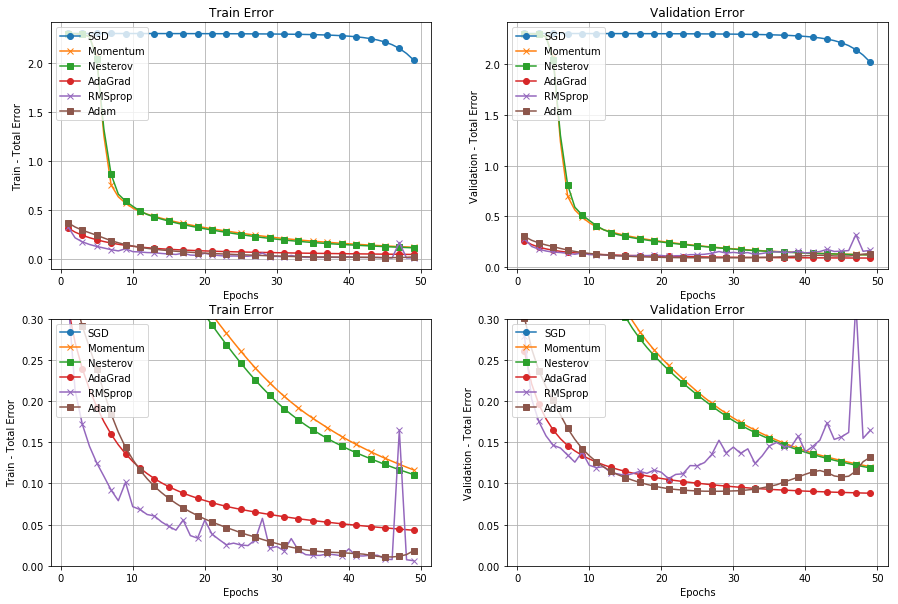

In [58]:
markers = {"SGD": "o", "Momentum": "x", "Nesterov": "s", "AdaGrad": "o", "RMSprop": "x", "Adam": "s"}

f, axarr = plt.subplots(2, 2, figsize=(15,10))
for j in optimizers.keys():
    axarr[0, 0].plot(epoch_list[1:], train_errors[j][1:], marker=markers[j], markevery=2, label=j)
axarr[0, 0].set_ylabel('Train - Total Error')
axarr[0, 0].set_xlabel('Epochs')
axarr[0, 0].grid(True)
axarr[0, 0].set_title('Train Error')
axarr[0, 0].legend(loc='upper left')

for j in optimizers.keys():
    axarr[0, 1].plot(epoch_list[1:], validation_errors[j][1:], marker=markers[j], markevery=2, label=j)
axarr[0, 1].set_ylabel('Validation - Total Error')
axarr[0, 1].set_xlabel('Epochs')
axarr[0, 1].grid(True)
axarr[0, 1].set_title('Validation Error')
axarr[0, 1].legend(loc='upper left')

for j in optimizers.keys():
    axarr[1, 0].plot(epoch_list[1:], train_errors[j][1:], marker=markers[j], markevery=2, label=j)
axarr[1, 0].set_ylabel('Train - Total Error')
axarr[1, 0].set_xlabel('Epochs')
axarr[1, 0].grid(True)
axarr[1, 0].set_ylim(0, 0.3)
axarr[1, 0].set_title('Train Error')
axarr[1, 0].legend(loc='upper left')

for j in optimizers.keys():
    axarr[1, 1].plot(epoch_list[1:], validation_errors[j][1:], marker=markers[j], markevery=2, label=j)
axarr[1, 1].set_ylabel('Validation - Total Error')
axarr[1, 1].set_xlabel('Epochs')
axarr[1, 1].grid(True)
axarr[1, 1].set_ylim(0, 0.3)
axarr[1, 1].set_title('Validation Error')
axarr[1, 1].legend(loc='upper left')

plt.show()

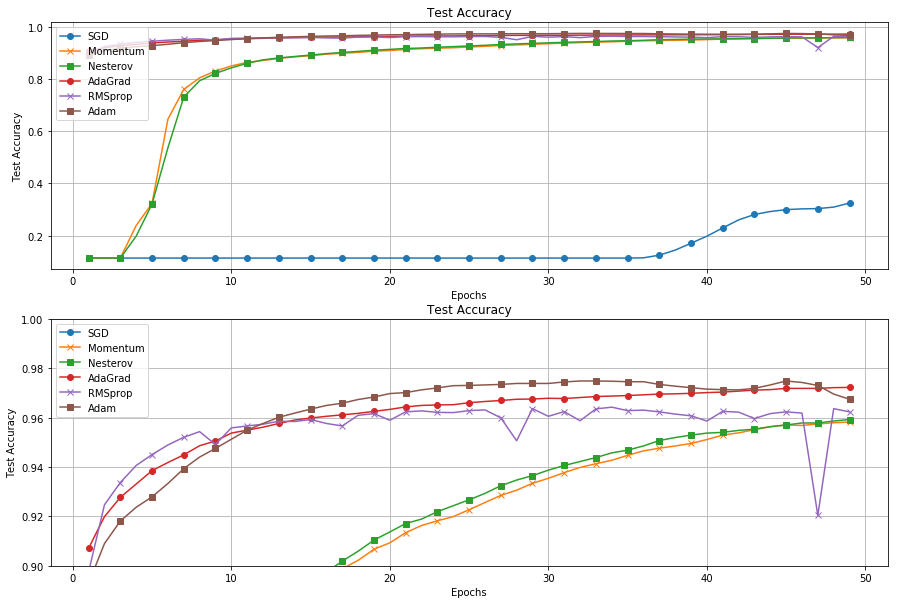

In [57]:
f, axarr = plt.subplots(2, 1, figsize=(15,10))
for j in optimizers.keys():
    axarr[0].plot(epoch_list[1:], test_accuracy_values[j][1:], marker=markers[j], markevery=2, label=j)
axarr[0].set_ylabel('Test Accuracy')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Test Accuracy')
axarr[0].legend(loc='upper left')

for j in optimizers.keys():
    axarr[1].plot(epoch_list[1:], test_accuracy_values[j][1:], marker=markers[j], markevery=2, label=j)
axarr[1].set_ylabel('Test Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_ylim(0.9, 1.0)
axarr[1].set_title('Test Accuracy')
axarr[1].legend(loc='upper left')
plt.show()